In [1]:
# 密度聚类

# 通过评估样本的紧密程度来划分对应的类别，理论上可以找出任何形状的聚类并有效避免噪声的干扰,也无需像划分聚类那样提前声明需要聚集的类别数量


# 层次聚类和划分聚类共有的缺点：无法很好地接近非凸（non-convex）数据的聚类问题

In [2]:
# DBSCAN 密度聚类算法

# density-based spatial clustering of applications with noise,具有噪声的基于密度的聚类方法,由 Martin Ester 等在 1996 年提出
# 可以在有噪音的数据中发现形状与大小各异的类别



In [3]:
# DBSCAN 聚类算法实现

#  一般假定样本的类别可以通过样本分布的紧密程度决定，于是先发现密度较高的点，然后把相近的高密度点逐步连成一片，进而找到不同的类别（簇）

# 1.首先，DBSCAN 会以每个数据点为圆心，以 eps（σ-邻域） 为半径画圆。
# 2.然后，DBSCAN 会计算相应圆中有多少个其他点，并以该数目作为圆心数据点的密度值。
# 3.接下来，我们需要确定密度阈值 MinPts，并分别将小于或大于该密度阈值的数据点（包含自己）称作低密度或高密度点（核心点）。
# 4.如果，此时有一个高密度的点在另一个高密度的点的圆圈范围内，我们就把这两个点串联起来。
# 5.之后，如果有低密度的点也在高密度的点的圆圈范围内，也将其连接到最近的高密度点上，并称之为边界点。

# 最后，所有能连到一起的数据点就形成了一个聚类类别


# N(xj) = distance(xi,xj) <= σ-邻域
# 点两两间的距离小于距离的，划分为子样本集的数量

# 核心对象：如果某个样本集包含了 >= MinPts 个样本，则该样本集被称为核心对象。
# 密度直达：xi 位于 xj 的邻域中,xj 是核心对象，则 xi 由 xj 密度直达
# 密度可达：密度直达具有传播性，例如有样本 p1、p2......pn,分别 pn+1 由 pn 密度直达，那 p1 和 pn 成为密度可达
# 密度相连：由核心对象密度直达的任意两个点，它们的关系成为密度相连

In [4]:
from sklearn import datasets

noisy_moons, _ = datasets.make_moons(
    n_samples=100, noise=0.05, random_state=10
)  # 生成 100 个样本并添加噪声
noisy_moons[:5]

array([[ 0.2554364 ,  0.90420806],
       [ 0.55299636,  0.84445141],
       [-0.90343862,  0.39161309],
       [-0.62792219,  0.62502915],
       [ 0.60777269, -0.33777687]])

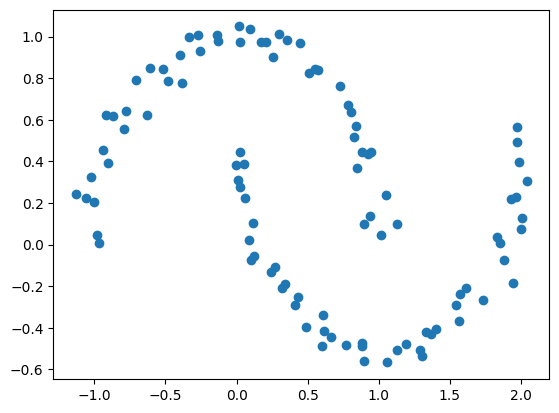

In [5]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1])

Text(0.5, 0, 'BIRCH')

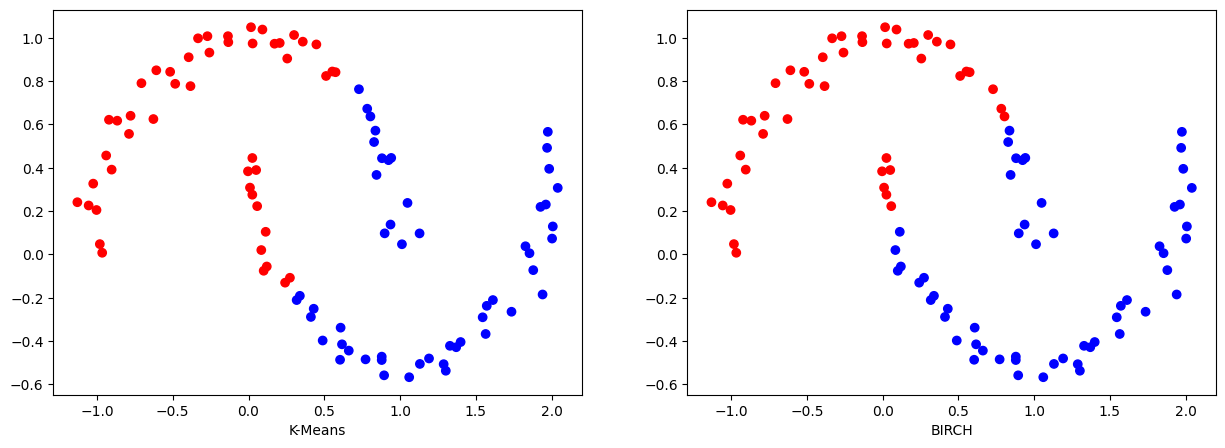

In [6]:
from sklearn.cluster import KMeans, Birch

# 分别尝试使用 划分聚类 KN 和 层次聚类 Birch 进行聚类，对比效果
kmeans_c = KMeans(n_clusters=2, n_init="auto").fit_predict(noisy_moons)
birch_c = Birch(n_clusters=2).fit_predict(noisy_moons)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=kmeans_c, cmap="bwr")
axes[1].scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=birch_c, cmap="bwr")
axes[0].set_xlabel("K-Means")
axes[1].set_xlabel("BIRCH")

In [7]:
import numpy as np


def euclidean_distance(a, b):
    """
    参数:
    a -- 数组 a
    b -- 数组 b

    返回:
    dist -- a, b 间欧式距离
    """
    # 欧式距离
    x = float(a[0]) - float(b[0])
    x = x * x
    y = float(a[1]) - float(b[1])
    y = y * y
    dist = round(np.sqrt(x + y), 2)
    return dist

In [8]:
# 第一步：以点为圆心，eps 为半径寻找范围邻点
def search_neighbors(D, P, eps):
    """
    参数:
    D -- 数据集（二维数组）
    P -- 核心点的序号
    eps -- eps 邻域

    返回:
    neighbors -- 核心点在 eps 范围内的邻居
    """
    # 找出数据集中距核心点 P 在 eps 范围内的邻近点的序号
    neighbors = []
    for Pn in range(0, len(D)):
        # 距离判断是否在 eps 范围内
        if euclidean_distance(D[P], D[Pn]) < eps:
            neighbors.append(Pn)

    return neighbors

In [9]:
def dbscan_cluster(D, eps, MinPts):
    """
    参数:
    D -- 数据集（二维数组）
    eps -- eps 邻域
    MinPts -- 密度阀值

    返回:
    labels -- 聚类标签
    """
    # DBSCAN 密度聚类算法
    labels = [0] * len(D)  # 初始化数据集中的数据类别全部为 0,生成 len(D)个分类
    C = 0
    # 选择 P 作为核心点
    for P in range(0, len(D)):
        # 选择类别为 0 的点作为中心
        if not (labels[P] == 0):
            continue

        # 搜寻该数据点在 eps 圆中的邻居
        Neighbors = search_neighbors(D, P, eps)

        # 标记噪声点为 -1，小于 MinPts 表示这个核心点周围的密度不够，此点不作为分类，看后面有没被认领
        if len(Neighbors) < MinPts:
            labels[P] = -1

        # 非噪声点作为新类别中心
        else:
            C += 1  # 原类别 +1 作为新类别的标签
            labels[P] = C  # 将非噪声点设定为新类别

            # 开始检查 P 在 eps 圆中邻居的可达性，下面会增长 Neighbors
            for i, n in enumerate(Neighbors):
                Pn = Neighbors[i]  # 从 P 的邻居中取 1 个点

                # 把符合条件的邻点划分为一类
                # P 的邻居，设定为一样的类别
                if labels[Pn] == 0:
                    labels[Pn] = C

                    # 进一步搜索 P 的邻居的邻居，以Pn为新的核心点，继续寻找合适的点
                    PnNeighbors = search_neighbors(D, Pn, eps)
                    if len(PnNeighbors) >= MinPts:  # 如果满足密度阈值要求则连通
                        Neighbors += PnNeighbors

                # 如果该点曾被标记为噪声点, 则重新连接到类别中
                elif labels[Pn] == -1:
                    labels[Pn] = C

    return labels

In [10]:
# 计算所有数据点的分类
dbscan_c = dbscan_cluster(noisy_moons, eps=0.5, MinPts=5)
np.array(dbscan_c)  # 显示聚类标签

array([1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1])

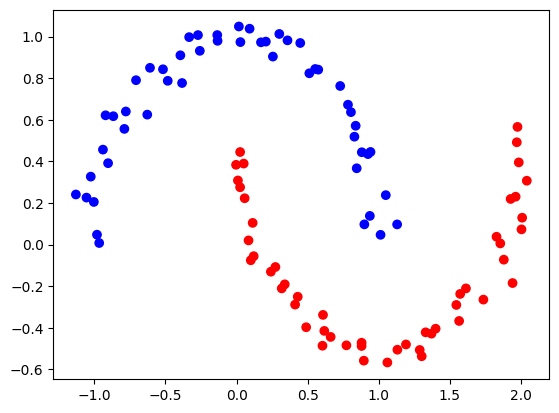

In [11]:
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=dbscan_c, cmap="bwr")

In [12]:
# sklearn.cluster.DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=1)


# eps: 即 epsilon-邻域的值。

# min_samples: 即密度阈值 MinPts 的值。

# metric: 距离度量方式，默认为欧式距离。

# algorithm：近邻算法求解方式：auto, ball_tree, kd_tree, brute 可选


In [13]:
from sklearn.cluster import DBSCAN

dbscan_sk = DBSCAN(eps=0.5, min_samples=5, metric="euclidean")
dbscan_sk_c = dbscan_sk.fit_predict(noisy_moons)
dbscan_sk_c

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0], dtype=int64)

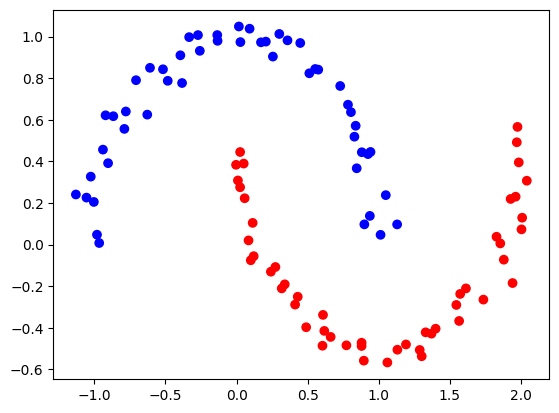

In [14]:
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], c=dbscan_sk_c, cmap="bwr")

In [15]:
# HDBSCAN

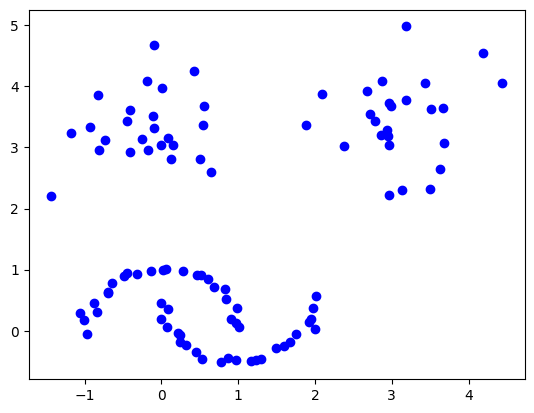

In [16]:
moons, _ = datasets.make_moons(n_samples=50, noise=0.05, random_state=10)
blobs, _ = datasets.make_blobs(
    n_samples=50, centers=[(-0.25, 3.25), (3, 3.5)], cluster_std=0.6, random_state=10
)

noisy_moons_blobs = np.vstack([moons, blobs])
plt.scatter(noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], color="b")

In [17]:
dbscan_sk_c = dbscan_sk.fit_predict(noisy_moons_blobs)
dbscan_sk_c

array([ 0,  1,  0,  0,  0,  1,  1,  0,  1,  1,  0,  1,  0,  0,  1,  1,  0,
        0,  1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  0,
        1,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0,  1, -1,
        2, -1,  2,  2, -1,  3,  3,  3,  2,  3, -1,  3,  2,  3,  2, -1,  2,
        2, -1,  2,  3,  3,  2, -1, -1,  3, -1,  3,  2, -1,  3, -1,  3,  2,
        3,  3, -1,  2, -1, -1,  2,  3,  3, -1, -1, -1,  3,  3,  3],
      dtype=int64)

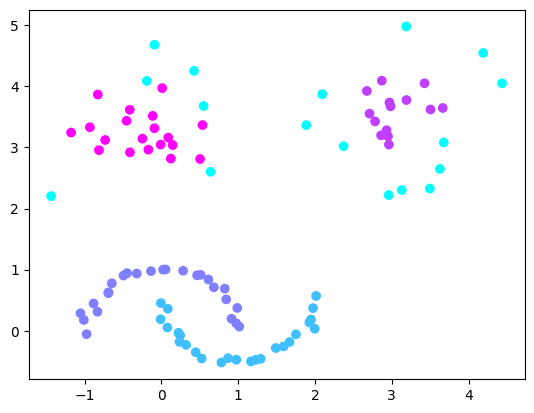

In [18]:
plt.scatter(
    noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], c=dbscan_sk_c, cmap="cool"
)

In [19]:
# DBSCAN 算法将 noisy_moons_blobs 数据集聚为了 4 类，但是实际上应该是 3 类

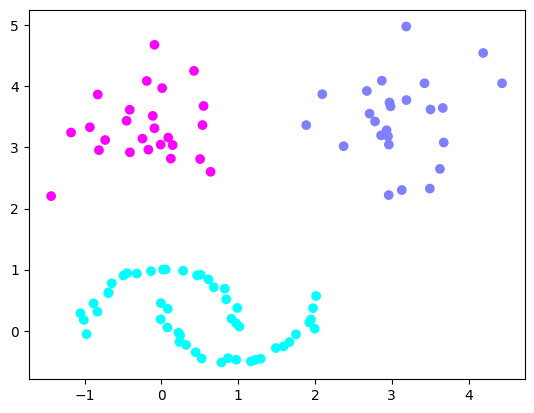

In [20]:
# 调大 eps
dbscan_sk = DBSCAN(eps=1, min_samples=5, metric="euclidean")
dbscan_sk_c = dbscan_sk.fit_predict(noisy_moons_blobs)
plt.scatter(
    noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], c=dbscan_sk_c, cmap="cool"
)

In [21]:
import hdbscan

# gen_min_span_tree 参数为下文绘图做准备
hdbscan_m = hdbscan.HDBSCAN(gen_min_span_tree=True)
hdbscan_m_c = hdbscan_m.fit_predict(noisy_moons_blobs)

plt.scatter(
    noisy_moons_blobs[:, 0], noisy_moons_blobs[:, 1], c=hdbscan_m_c, cmap="winter"
)

ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
plt.figure(figsize=(15, 8))
hdbscan_m.minimum_spanning_tree_.plot(
    edge_cmap="viridis", edge_alpha=0.4, node_size=90, edge_linewidth=3
)

In [ ]:
plt.figure(figsize=(15, 8))
hdbscan_m.single_linkage_tree_.plot(cmap="viridis", colorbar=True)

In [ ]:
plt.figure(figsize=(15, 8))
hdbscan_m.condensed_tree_.plot()